# CNN interpretation with CAM

## CAM and hooks

In [ ]:
path = untar_data(URLs.PETS)/'images'
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.169129,0.018994,0.005413,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.073098,0.022175,0.006766,00:18


In [ ]:
img = PILImage.create('images/chapter1_cat_example.jpg')
x,y = dls.one_item(img)

In [ ]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [ ]:
hook_output = Hook()
hook = learn.model[0][-1].register_forward_hook(hook_output.hook_func)

In [ ]:
with torch.no_grad(): output = learn.model.eval()(x.cuda())

In [ ]:
act = hook_output.stored[0]

In [ ]:
cam_map = torch.einsum('ck,kij->cij', learn.model[-1].weight, act)
cam_map.shape

torch.Size([2, 7, 7])

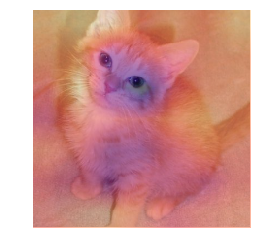

In [ ]:
_,ax = plt.subplots()
ax.imshow(data.denorm(x)[0].cpu().numpy().transpose(1,2,0))
ax.axis('off')
ax.imshow(cam_map[0].cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
data.classes

['cat', 'dog']

In [ ]:
output

tensor([[-1.5874,  1.7091]], device='cuda:0')

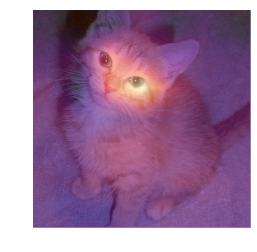

In [ ]:
_,ax = plt.subplots()
ax.imshow(data.denorm(x)[0].cpu().numpy().transpose(1,2,0))
ax.axis('off')
ax.imshow(cam_map[1].cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
hook.remove()

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
with Hook(learn.model[-4]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored

## Gradient CAM

In [ ]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
cls = 0
with HookBwd(learn.model[-4]) as hookg:
    with Hook(learn.model[-4]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

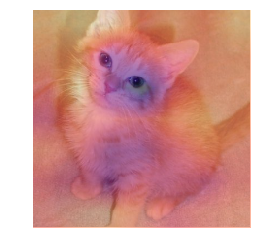

In [ ]:
_,ax = plt.subplots()
ax.imshow(data.denorm(x)[0].cpu().numpy().transpose(1,2,0))
ax.axis('off')
ax.imshow(cam_map.cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
(learn.model[-1].weight[0] / w.squeeze())[:10]

tensor([49.0000, 49.0000, 49.0000, 49.0000, 49.0000, 49.0000, 49.0000, 49.0000,
        49.0000, 49.0000], device='cuda:0', grad_fn=<SliceBackward>)

In [ ]:
with HookBwd(learn.model[-5]) as hookg:
    with Hook(learn.model[-5]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

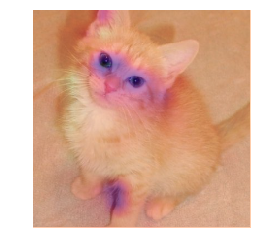

In [ ]:
_,ax = plt.subplots()
ax.imshow(data.denorm(x)[0].cpu().numpy().transpose(1,2,0))
ax.axis('off')
ax.imshow(cam_map.cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');